# Testing variable chirp stacks

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    20:24:48 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    20:24:48 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    20:24:48 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
# open client
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42795")
client

<Client: 'tcp://127.0.0.1:42795' processes=4 threads=16, memory=125.81 GiB>

In [4]:
# define function to use portion of chirp
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

# function to plot chirp histograms
def plot_hist(ds,ylim=False):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(ncols=atten_count,figsize=(5*atten_count,5))
    
    for i in range(atten_count):
        ds.chirp.isel(attenuator_setting_pair=i).mean(dim='chirp_num').plot.hist(ax=axs[i],bins=100)
        axs[i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[i].set_ylabel('count')
        axs[i].set_xlabel('chirp voltage [V]')
        if ylim:
            old_lim = axs[i].get_ylim()
            axs[i].set_ylim([old_lim[0],old_lim[1]*0.2])

def plot_amplitude_trends(ds):
    atten_count = len(ds.attenuator_setting_pair)
    fig, axs = plt.subplots(nrows=3,ncols=atten_count,figsize=(5*atten_count,15))
    for i in range(atten_count):
        # Over chirp 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_num','time'])[1:-1].plot(ax=axs[0][i],linestyle='None',marker='.',label='mean')
        axs[0][i].set_title(f'G = {int(ds.AFGain[i].values)} dB, A = {int(ds.attenuator[i].values)} dB')
        axs[0][i].set_ylabel('')
        axs[0][i].set_xlabel('chirp time')
        axs[0][i].legend()

        # Over chirp number 
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','time']).plot(ax=axs[1][i],linestyle='None',marker='.',label='mean')
        axs[1][i].set_ylabel('')
        axs[1][i].set_xlabel('chirp number')
        axs[1][i].set_title('')

        # over burst time
        abs(ds.isel(attenuator_setting_pair = i).chirp).max(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='max')
        abs(ds.isel(attenuator_setting_pair = i).chirp).mean(dim=['chirp_time','chirp_num']).plot(ax=axs[2][i],linestyle='None',marker='.',label='mean')
        axs[2][i].set_ylabel('')
        axs[2][i].set_xlabel('date')
        axs[2][i].set_title('')
    
    axs[0][0].set_ylabel('chirp magnitude over chirp time [V]')
    axs[1][0].set_ylabel('chirp magnitude over chirp number [V]')
    axs[2][0].set_ylabel('burst magnitude over time [V]')

def plot_bad_chirp_count(ds):
    # input ds should be the form of ds.isel(attenuator_setting_pair=i).chirp.where(condition)
    fig, axs = plt.subplots(ncols=3,figsize=(15,5),layout='tight')
    ds.count(dim=['chirp_num','time']).plot(ax=axs[0],linestyle='None',marker='.')
    axs[0].set_ylabel('count')
    axs[0].set_title('Total instances of clipping in chirp section')
    
    (ds.max(dim='chirp_time').count(dim='time')/(ds.max(dim='chirp_time').count())).plot(ax=axs[1],linestyle='None',marker='.')
    axs[1].set_ylabel('fraction of total clipped chirps')
    axs[1].set_title('Clipped chirp distribution by chirp number')
    
    ds.max(dim='chirp_time').count(dim='chirp_num').plot(ax=axs[2],linestyle='None',marker='.')
    axs[2].set_ylabel('count')
    axs[2].set_title('Number of chirps with clipping in each burst')

def plot_profile(example_chirp):
    fig, axs = plt.subplots(ncols=2,figsize=(10,5))
    for i in [0,1]:
        example_chirp.isel(attenuator_setting_pair = i).chirp.mean(dim='chirp_num').plot(ax=axs[0],label = f'G = {int(example_chirp.AFGain[i].values)} dB, A = {int(example_chirp.attenuator[i].values)} dB')
        xa.dB(example_chirp.isel(attenuator_setting_pair = i).profile_stacked).plot(ax=axs[1])
    axs[0].legend()
    axs[0].set_title('Chirp')
    axs[0].set_ylabel('voltage [V]')
    axs[0].set_xlabel('chirp time [ns]')
    
    axs[1].set_title('Profile')
    axs[1].set_ylabel('reflector amplitude [dB]')
    axs[0].set_xlabel('range [m]')

# Repurpose another function to compare strain rate estimates based on window
def generate_strain_fit(ds,window,lag,lims=None):
    # New method
    profile = ds.profile_stacked.isel(attenuator_setting_pair=0).compute()
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    
    # Old Method
    profile = custom_stacked_profile_series(ds.chirp.isel(attenuator_setting_pair=0,chirp_num=range(10,20)),2)
    b1= profile.isel(time=range(0,len(profile)-lag))
    b2 = profile.isel(time=range(lag,len(profile)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_old = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')
    vv_old = ds_old.range_diff / ds_old.time_diff * 31536000
    vv_old_err = ds_old.err / ds_old.time_diff * 31536000
    fit_old=vv_old.where(vv_old.profile_range <=600).polyfit('profile_range',1,full=True)
    r2_old = 1-fit_old.polyfit_residuals/((vv_old-vv_old.mean())**2).sum(dim='profile_range')
    
    # Plotting
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='Chirps 1-20')
    axs[0].plot(fit_old.time.values,fit_old.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',alpha=0.2,label='Chirps 10-20')
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[0].legend(loc="upper left", ncol=2)
    axs[0].set_ylim([-0.01, 0])

    axs[1].plot(fit.time.values,r2.values,linestyle='None',marker='.')
    axs[1].plot(fit_old.time.values,r2_old.values,linestyle='None',marker='.',alpha=0.2)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    
    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv_old.time)),len(vv_old.time),len(vv_old.time)//10)
    for i in range(10):
        time = vv_old.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=1)
        axs_1[i].errorbar(vv_old.sel(time = time,method="nearest") ,vv_old.profile_range,yerr=None,xerr=vv_old_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=2)
        #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if lims:
            axs_1[i].set_xlim(lims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
    return vv,vv_err,vv_old,vv_old_err

In [5]:
# use some "good data"
good_bursts = ds_101_w.isel(attenuator_setting_pair=0,time=range(5000,6000)).chirp.compute()

In [6]:
# divide up into bursts with all 20 chirps, bursts with last 10 chirps
chirps_20 = good_bursts
chirps_10 = good_bursts.isel(chirp_num=range(10,20))
chirps_5 = good_bursts.isel(chirp_num=range(15,20))

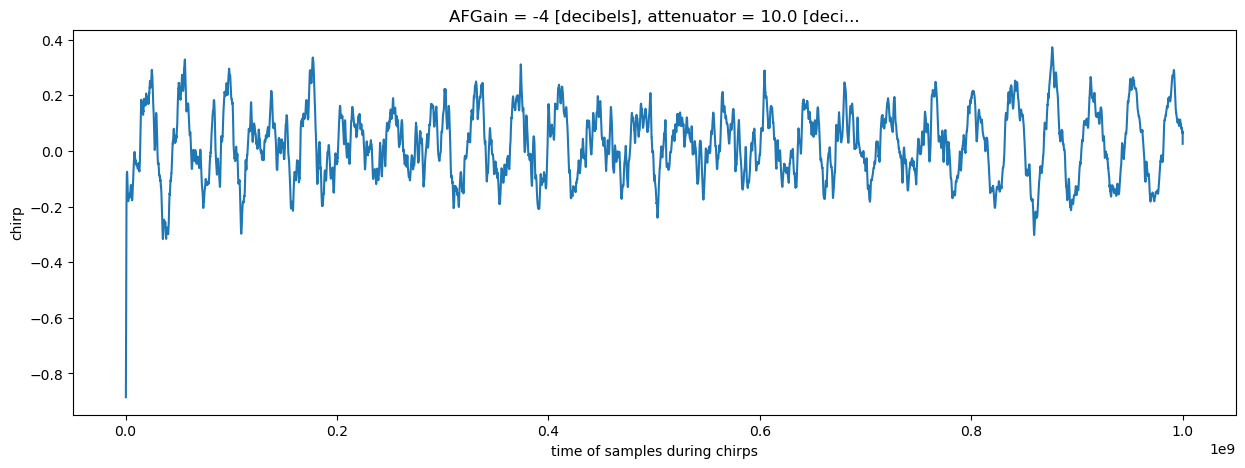

In [17]:
fig,ax = plt.subplots(figsize=(15,5))
chirps_20.mean(dim=['chirp_num','time'])[10:-1].plot()
#chirps_10.mean(dim=['chirp_num','time'])[2:-1].plot()
#chirps_5.mean(dim=['chirp_num','time'])[2:-1].plot()

Aside. Look at the distribution of weird chirp portions

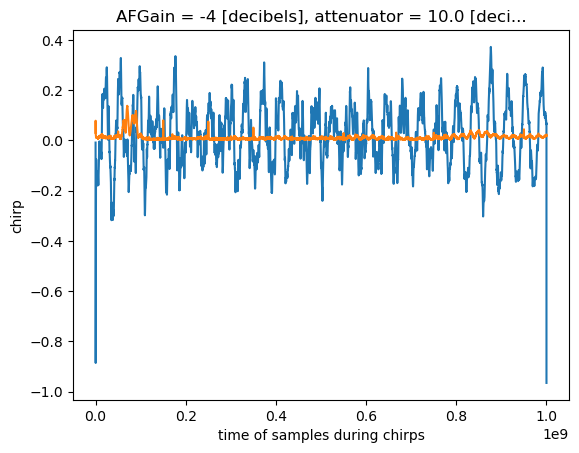

In [9]:
chirps_20.mean(dim=['chirp_num','time']).plot()
chirps_20.std(dim=['chirp_num','time']).plot()

This tells me that across this window, these chirps are roughly all this shape

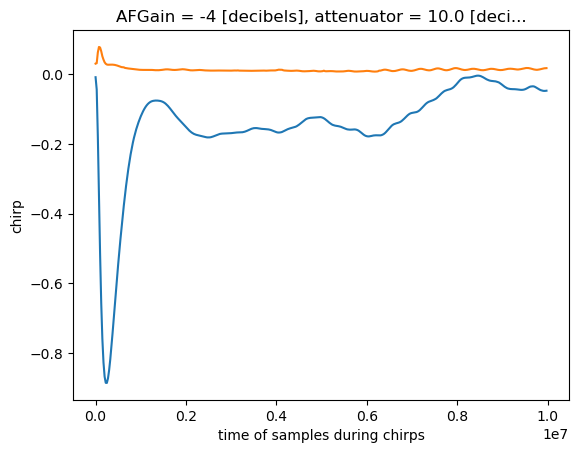

In [10]:
chirps_20.mean(dim=['chirp_num','time'])[0:400].plot()
chirps_20.std(dim=['chirp_num','time'])[0:400].plot()

For now, let's discard the first 200 samples, in addition to getting rid of the last one.

Now let's do our mean chirp plot but look at the mean difference.

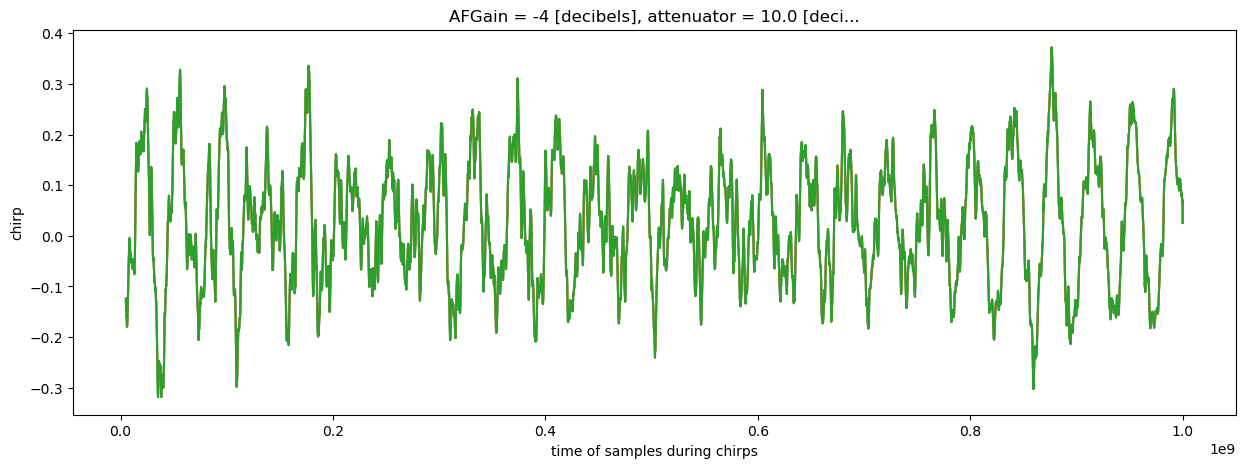

In [12]:
# mean plot
fig,ax = plt.subplots(figsize=(15,5))
chirps_20.mean(dim=['chirp_num','time'])[200:-1].plot()
chirps_10.mean(dim=['chirp_num','time'])[200:-1].plot()
chirps_5.mean(dim=['chirp_num','time'])[200:-1].plot()

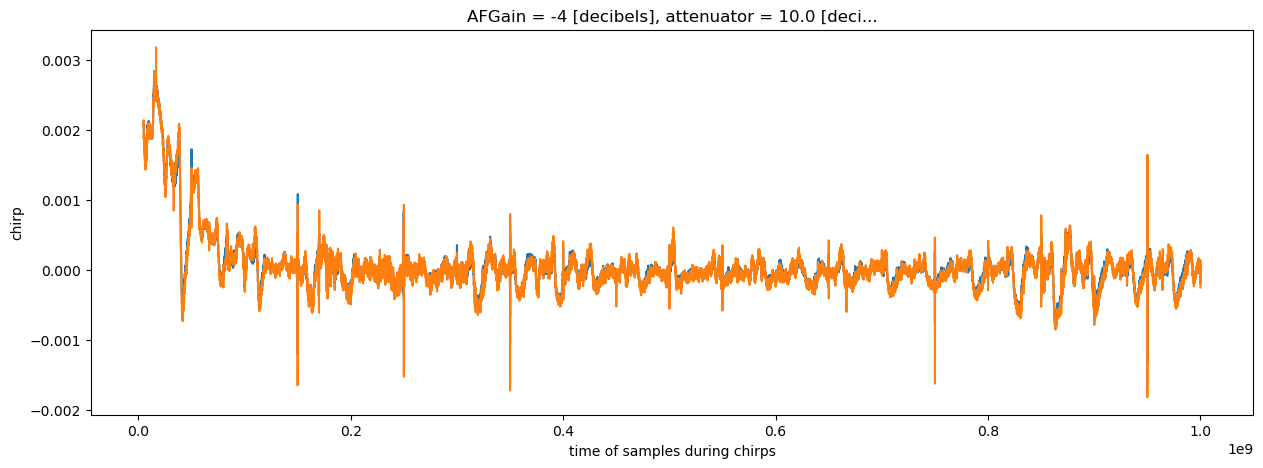

In [13]:
fig,ax = plt.subplots(figsize=(15,5))

(chirps_20.mean(dim=['chirp_num','time'])[200:-1]-chirps_10.mean(dim=['chirp_num','time'])[200:-1]).plot()
(chirps_20.mean(dim=['chirp_num','time'])[200:-1]-chirps_5.mean(dim=['chirp_num','time'])[200:-1]).plot()

Using the later bursts results in some positive bias at the beginning of the chirp. This is likely due to the elimination of the first chirp or two.

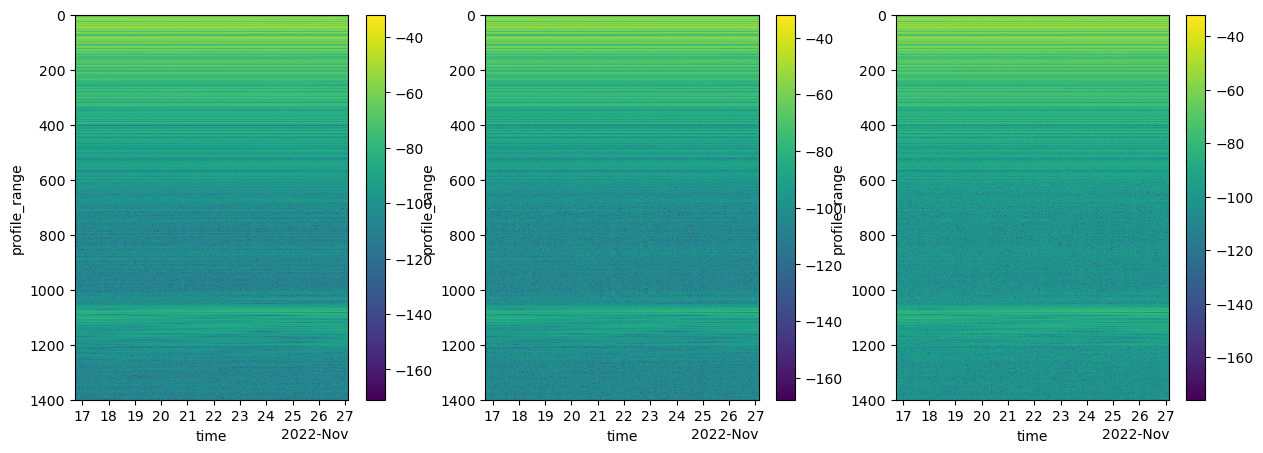

In [15]:
# get resulting profiles
profile_20 = custom_stacked_profile_series(chirps_20,2,2.01e8,4e8)
profile_10 = custom_stacked_profile_series(chirps_10,2,2.01e8,4e8)
profile_5 = custom_stacked_profile_series(chirps_5,2,2.01e8,4e8)


fig,axs = plt.subplots(ncols=3,figsize=(15,5))
xa.dB(profile_20).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
xa.dB(profile_10).plot(ax=axs[1],x='time')
axs[1].invert_yaxis()
xa.dB(profile_5).plot(ax=axs[2],x='time')
axs[2].invert_yaxis()

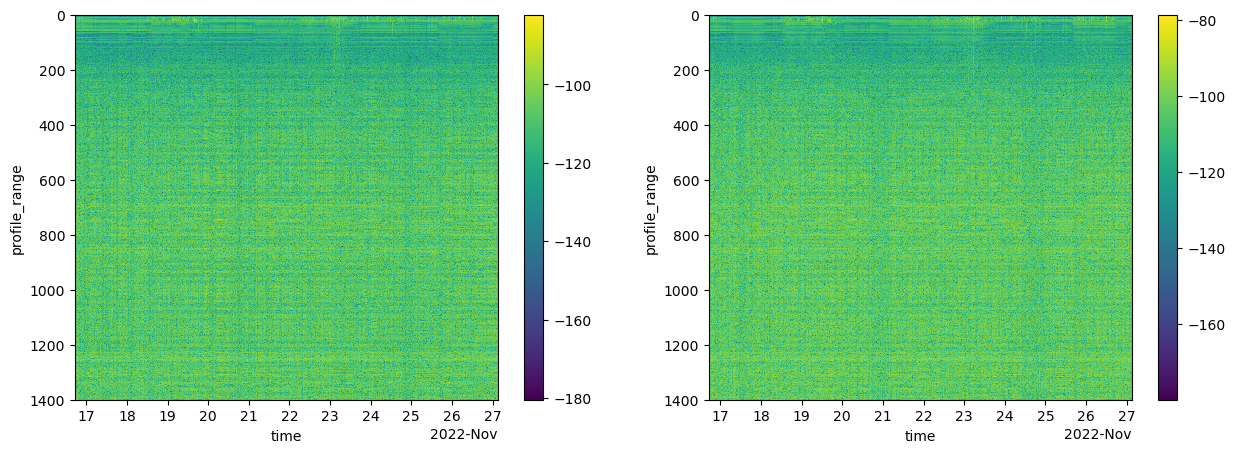

In [16]:
# plot differences
fig,axs = plt.subplots(ncols=2,figsize=(15,5))
xa.dB(profile_20-profile_10).plot(ax=axs[0],x='time')
axs[0].invert_yaxis()
xa.dB(profile_20-profile_5).plot(ax=axs[1],x='time')
axs[1].invert_yaxis()

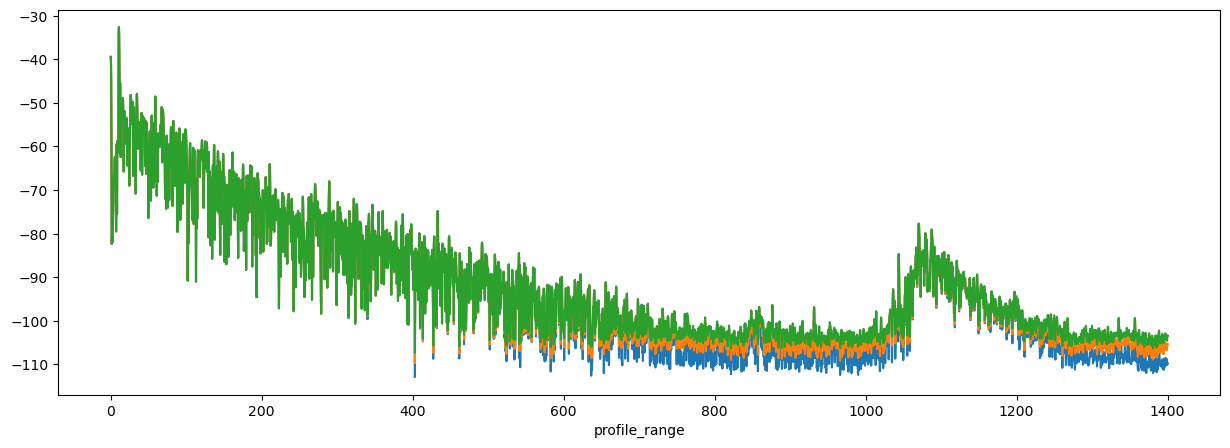

In [17]:
# mean profile
fig,ax = plt.subplots(figsize=(15,5))
xa.dB(profile_20).mean(dim='time').plot()
xa.dB(profile_10).mean(dim='time').plot()
xa.dB(profile_5).mean(dim='time').plot()



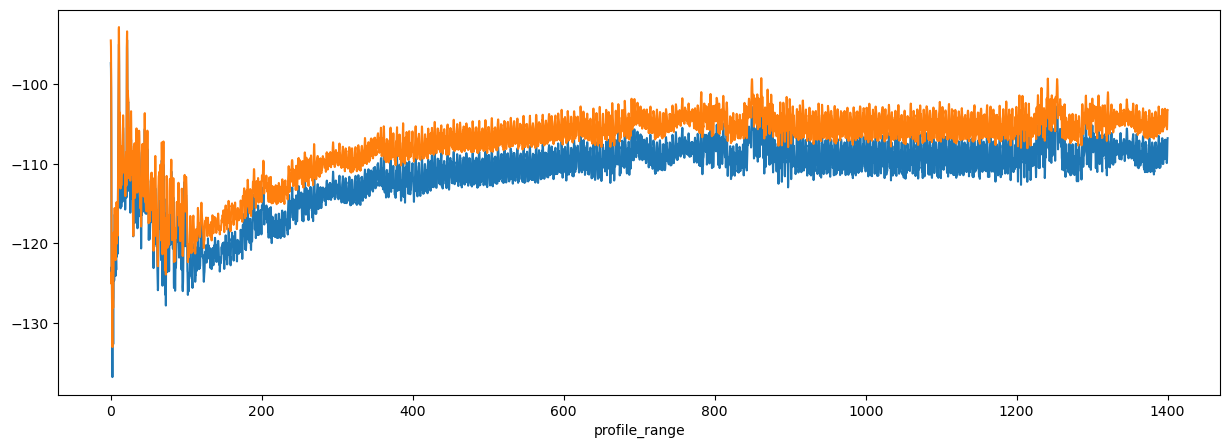

In [18]:
# difference
fig,ax = plt.subplots(figsize=(15,5))
xa.dB(profile_20-profile_10).mean(dim='time').plot()
xa.dB(profile_20-profile_5).mean(dim='time').plot()


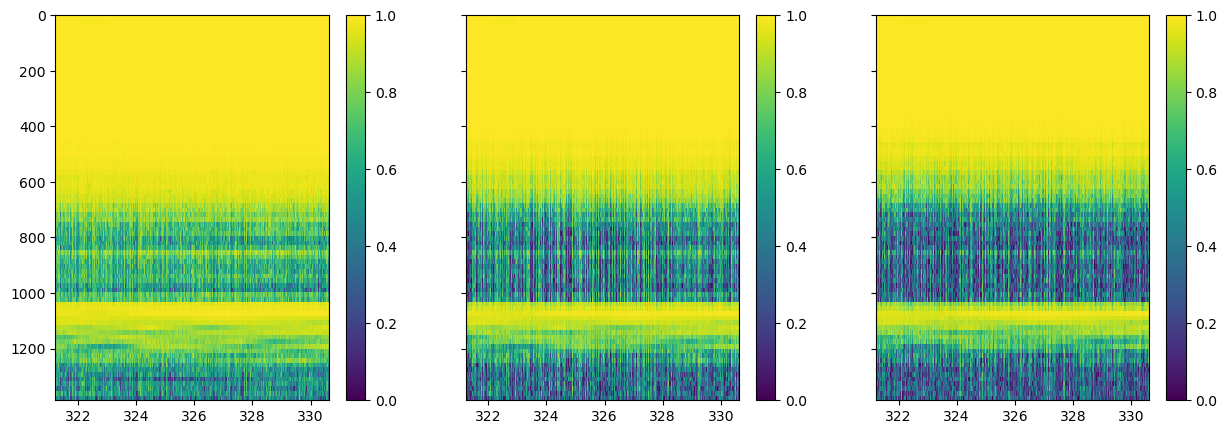

In [19]:
# coherence
lag = 96
window = 80
b1= profile_20.isel(time=range(0,len(profile_20)-lag))
b2 = profile_20.isel(time=range(lag,len(profile_20)))
ds_20, co_20, phi_20 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_20=ds_20.assign(coherence=(['time','profile_range'],co_20))
ds_20['doy_decimal'] = ds_20.time.dt.dayofyear + (ds_20.time.dt.hour / 24) + (ds_20.time.dt.minute / 1440) + (ds_20.time.dt.second / 86400)

b1= profile_10.isel(time=range(0,len(profile_10)-lag))
b2 = profile_10.isel(time=range(lag,len(profile_10)))
ds_10, co_10, phi_10 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_10=ds_10.assign(coherence=(['time','profile_range'],co_10))
ds_10['doy_decimal'] = ds_10.time.dt.dayofyear + (ds_10.time.dt.hour / 24) + (ds_10.time.dt.minute / 1440) + (ds_10.time.dt.second / 86400)

b1= profile_5.isel(time=range(0,len(profile_5)-lag))
b2 = profile_5.isel(time=range(lag,len(profile_5)))
ds_5, co_5, phi_5 = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
ds_5=ds_5.assign(coherence=(['time','profile_range'],co_5))
ds_5['doy_decimal'] = ds_5.time.dt.dayofyear + (ds_5.time.dt.hour / 24) + (ds_5.time.dt.minute / 1440) + (ds_5.time.dt.second / 86400)


fig,axs = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
fg = axs[0].pcolormesh(ds_20.doy_decimal,ds_20.profile_range,np.abs(co_20).T,vmin=0,vmax=1)
fg1 = axs[1].pcolormesh(ds_10.doy_decimal,ds_10.profile_range,np.abs(co_10).T,vmin=0,vmax=1)
fg2 = axs[2].pcolormesh(ds_5.doy_decimal,ds_5.profile_range,np.abs(co_5).T,vmin=0,vmax=1)

fig.colorbar(fg)
fig.colorbar(fg1)
fig.colorbar(fg2)


axs[0].invert_yaxis()


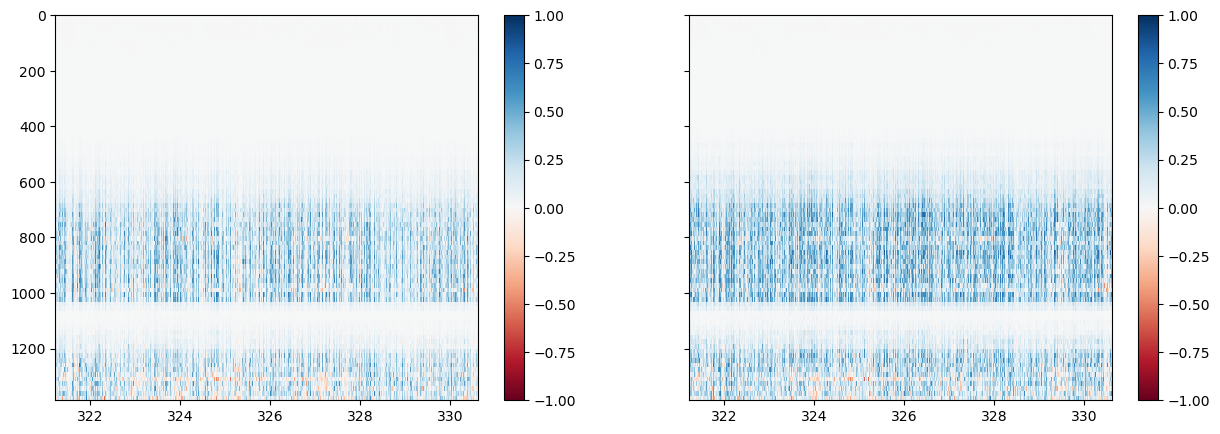

In [20]:
fig,axs = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
fg = axs[0].pcolormesh(ds_20.doy_decimal,ds_20.profile_range,np.abs(co_20).T-np.abs(co_10).T,vmin=-1,vmax=1,cmap='RdBu')
fg1 = axs[1].pcolormesh(ds_10.doy_decimal,ds_10.profile_range,np.abs(co_20).T-np.abs(co_5).T,vmin=-1,vmax=1,cmap='RdBu')

fig.colorbar(fg)
fig.colorbar(fg1)


axs[0].invert_yaxis()

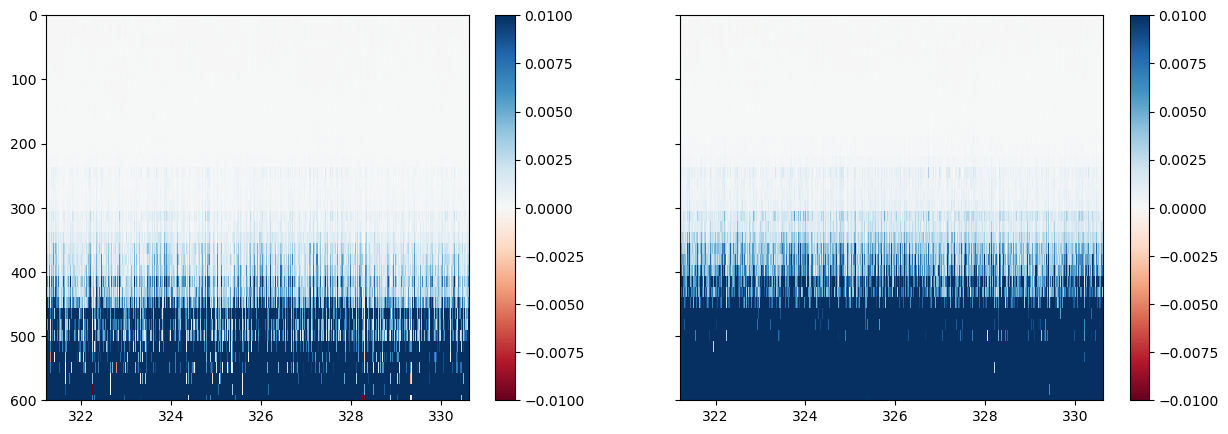

In [21]:
# zoom in on top
fig,axs = plt.subplots(ncols=2,figsize=(15,5),sharey=True)
fg = axs[0].pcolormesh(ds_20.doy_decimal,ds_20.profile_range,np.abs(co_20).T-np.abs(co_10).T,vmin=-0.01,vmax=0.01,cmap='RdBu')
fg1 = axs[1].pcolormesh(ds_10.doy_decimal,ds_10.profile_range,np.abs(co_20).T-np.abs(co_5).T,vmin=-0.01,vmax=0.01,cmap='RdBu')

fig.colorbar(fg)
fig.colorbar(fg1)

axs[0].set_ylim([0,600])
axs[0].invert_yaxis()

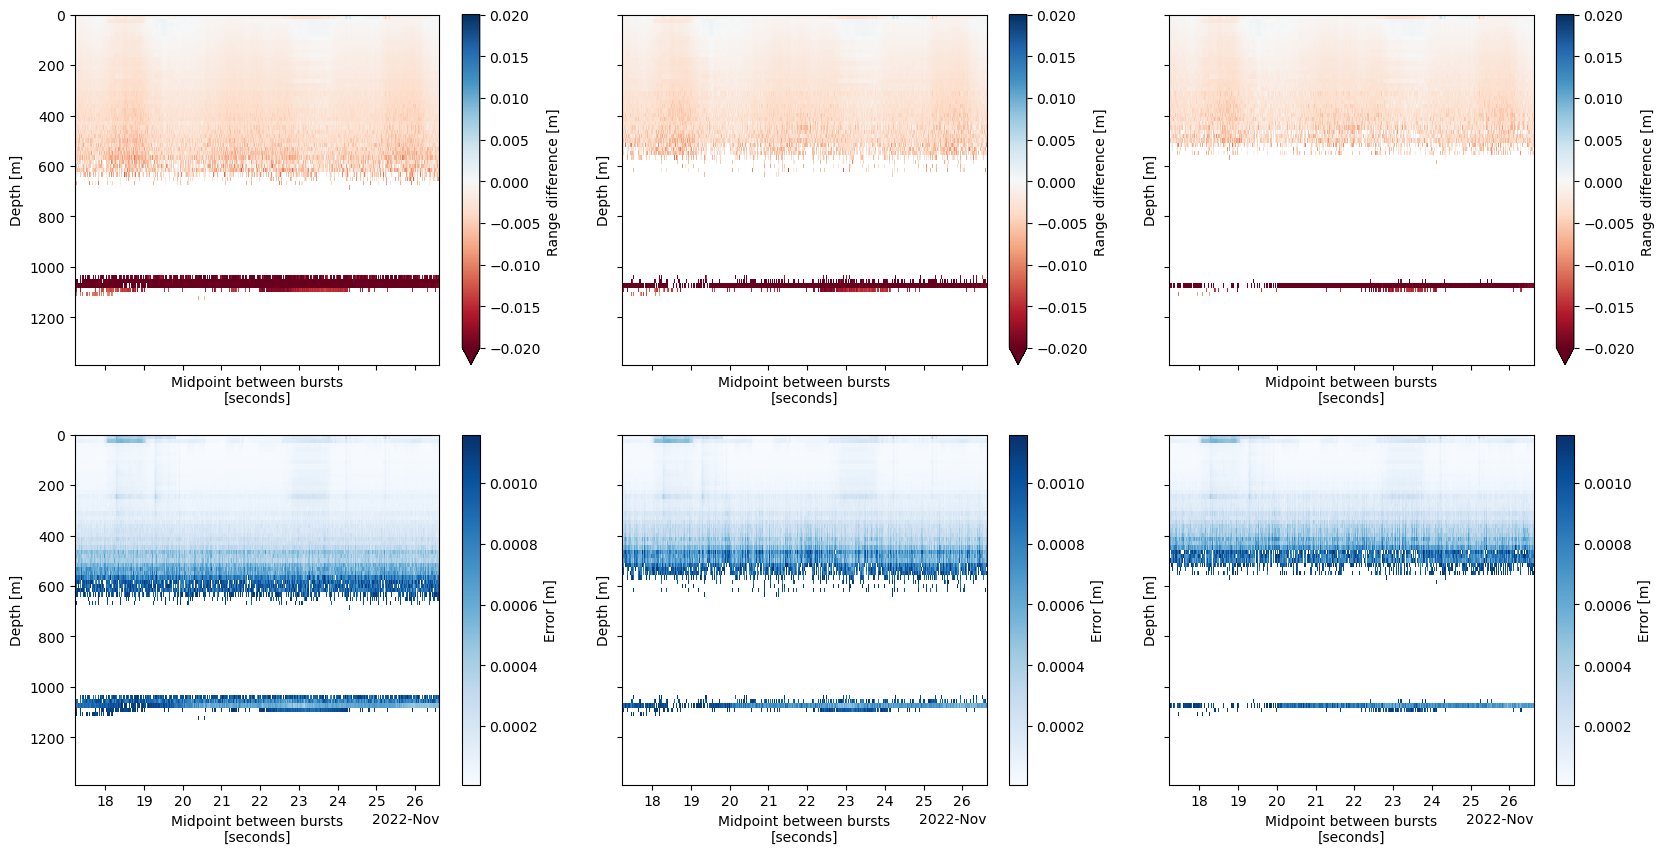

In [25]:
# Range_diff
fig, axs = plt.subplots(figsize=(20,10),ncols=3,nrows = 2,sharex = True,sharey=True)
ds_20 = ds_20.where(abs(ds_20.coherence) > 0.95).drop_duplicates('time')
ds_20.range_diff.plot(ax=axs[0][0],x='time',vmin=-0.02,vmax=0.02,cmap='RdBu')
ds_20.err.plot(ax=axs[1][0],x='time',cmap='Blues')
ds_10 = ds_10.where(abs(ds_10.coherence) > 0.95).drop_duplicates('time')
ds_10.range_diff.plot(ax=axs[0][1],x='time',vmin=-0.02,vmax=0.02,cmap='RdBu')
ds_10.err.plot(ax=axs[1][1],x='time',cmap='Blues')
ds_5 = ds_5.where(abs(ds_5.coherence) > 0.95).drop_duplicates('time')
ds_5.range_diff.plot(ax=axs[0][2],x='time',vmin=-0.02,vmax=0.02,cmap='RdBu')
ds_5.err.plot(ax=axs[1][2],x='time',cmap='Blues')
axs[0][0].invert_yaxis()


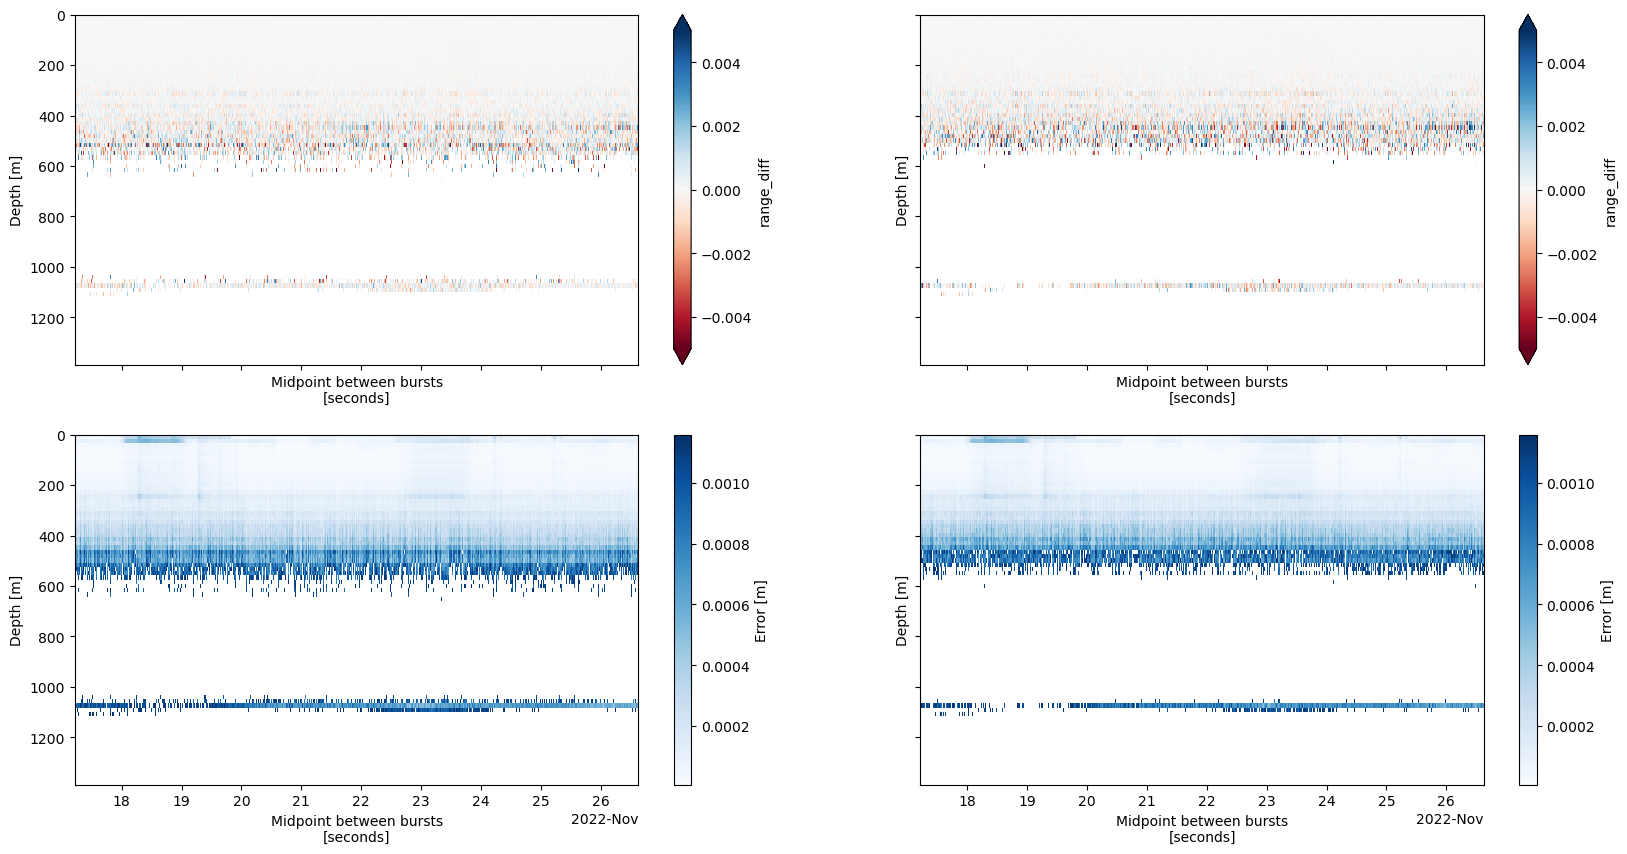

In [31]:
# deviation from Range_diff
fig, axs = plt.subplots(figsize=(20,10),ncols=2,nrows = 2,sharex = True,sharey=True)
(ds_20.range_diff-ds_10.range_diff).plot(ax=axs[0][0],x='time',vmin=-0.005,vmax=0.005,cmap='RdBu')
ds_10.err.plot(ax=axs[1][0],x='time',cmap='Blues')
(ds_20.range_diff-ds_5.range_diff).plot(ax=axs[0][1],x='time',vmin=-0.005,vmax=0.005,cmap='RdBu')
ds_5.err.plot(ax=axs[1][1],x='time',cmap='Blues')
axs[0][0].invert_yaxis()


In [30]:
vv_20 = ds_20.range_diff / ds_20.time_diff * 31536000
vv_20_err = ds_20.err / ds_20.time_diff * 31536000
fit_20=vv_20.where(vv_20.profile_range <=600).polyfit('profile_range',1,full=True)
r2_20 = 1-fit_20.polyfit_residuals/((vv_20.where(vv_20.profile_range <=600)-vv_20.where(vv_20.profile_range <=600).mean())**2).sum(dim='profile_range')
fit_20['doy_decimal'] = fit_20.time.dt.dayofyear + (fit_20.time.dt.hour / 24) + (fit_20.time.dt.minute / 1440) + (fit_20.time.dt.second / 86400)

vv_10 = ds_10.range_diff / ds_10.time_diff * 31536000
vv_10_err = ds_10.err / ds_10.time_diff * 31536000
fit_10=vv_10.where(vv_10.profile_range <=600).polyfit('profile_range',1,full=True)
r2_10 = 1-fit_10.polyfit_residuals/((vv_10.where(vv_10.profile_range <=600)-vv_10.where(vv_10.profile_range <=600).mean())**2).sum(dim='profile_range')
fit_10['doy_decimal'] = fit_10.time.dt.dayofyear + (fit_10.time.dt.hour / 24) + (fit_10.time.dt.minute / 1440) + (fit_10.time.dt.second / 86400)

vv_5 = ds_5.range_diff / ds_5.time_diff * 31536000
vv_5_err = ds_5.err / ds_5.time_diff * 31536000
fit_5=vv_5.where(vv_5.profile_range <=600).polyfit('profile_range',1,full=True)
r2_5 = 1-fit_5.polyfit_residuals/((vv_5.where(vv_5.profile_range <=600)-vv_5.where(vv_5.profile_range <=600).mean())**2).sum(dim='profile_range')
fit_5['doy_decimal'] = fit_5.time.dt.dayofyear + (fit_5.time.dt.hour / 24) + (fit_5.time.dt.minute / 1440) + (fit_5.time.dt.second / 86400)


Text(0, 0.5, 'r$^2$')

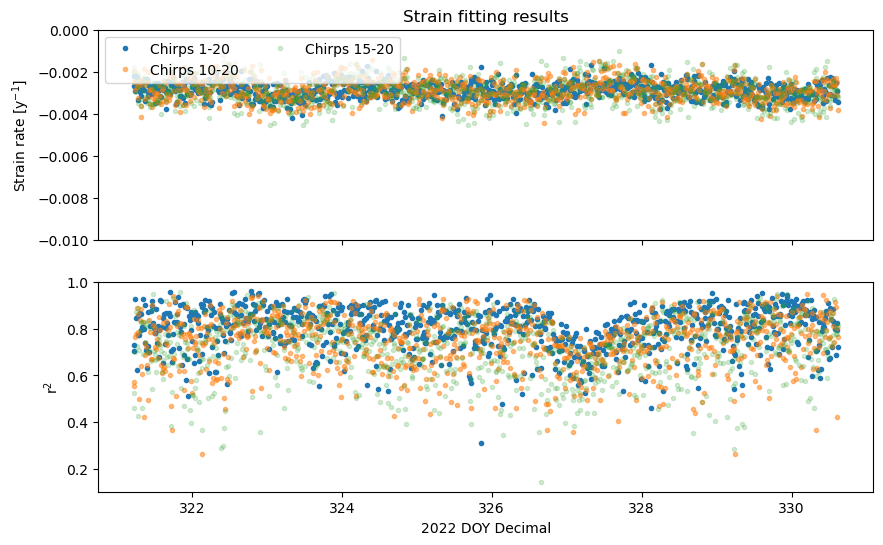

In [31]:
# Plotting
fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
axs[0].plot(fit_20.doy_decimal.values,fit_20.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='Chirps 1-20')
axs[0].plot(fit_10.doy_decimal.values,fit_10.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',alpha=0.5,label='Chirps 10-20')
axs[0].plot(fit_5.doy_decimal.values,fit_5.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',alpha=0.2,label='Chirps 15-20')
#axs[0].set_ylim([-1e-2,1e-2])
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
axs[0].legend(loc="upper left", ncol=2)
axs[0].set_ylim([-0.01, 0])

axs[1].plot(fit_20.doy_decimal.values,r2_20.values,linestyle='None',marker='.')
axs[1].plot(fit_10.doy_decimal.values,r2_10.values,linestyle='None',marker='.',alpha=0.5)
axs[1].plot(fit_5.doy_decimal.values,r2_5.values,linestyle='None',marker='.',alpha=0.2)

axs[1].set_xlabel('2022 DOY Decimal')
axs[1].set_ylabel('r$^2$')

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

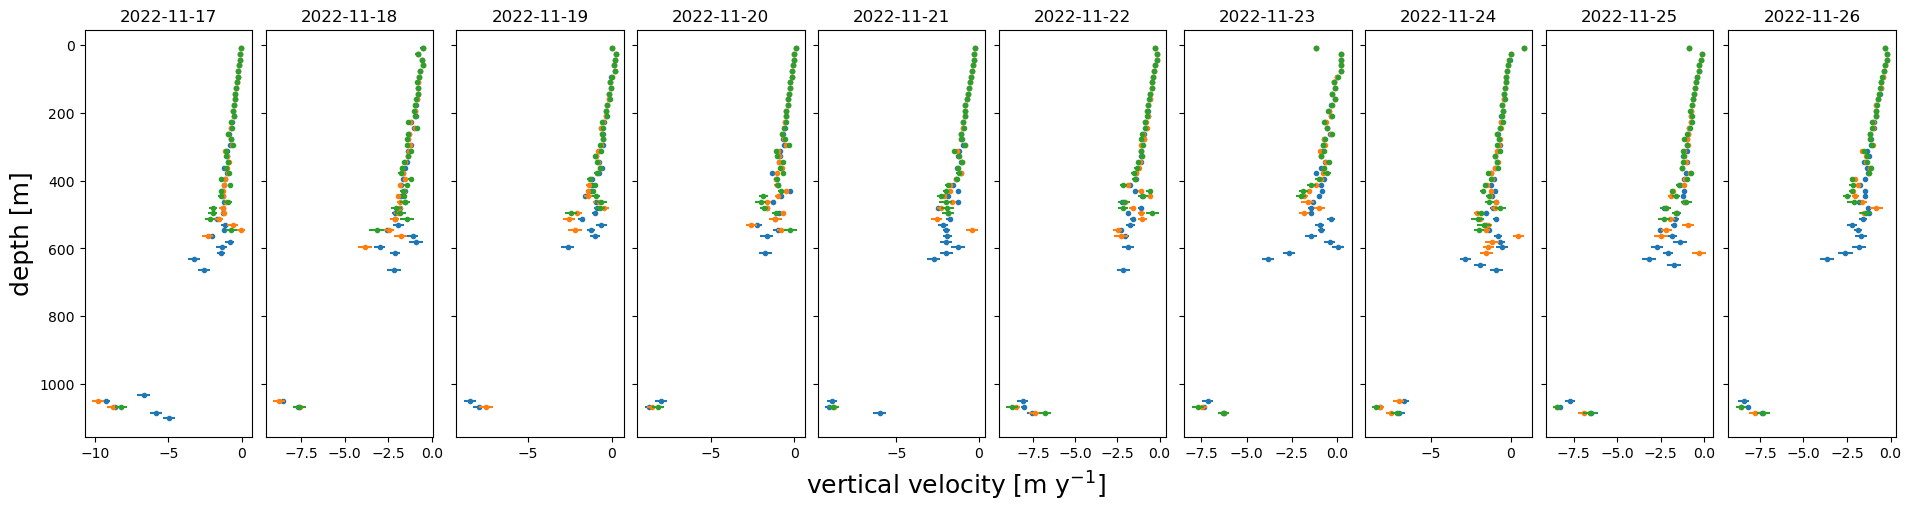

In [32]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
vv_times = np.arange(math.ceil(0.05*len(vv_10.time)),len(vv_10.time),len(vv_10.time)//10)
for i in range(10):
    time = vv_10.time.isel(time = vv_times[i]).values
    axs_1[i].errorbar(vv_20.sel(time = time,method="nearest") ,vv_20.profile_range,yerr=None,xerr=vv_20_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=1)
    axs_1[i].errorbar(vv_10.sel(time = time,method="nearest") ,vv_10.profile_range,yerr=None,xerr=vv_10_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=2)
    axs_1[i].errorbar(vv_5.sel(time = time,method="nearest") ,vv_5.profile_range,yerr=None,xerr=vv_5_err.sel(time = time,method="nearest"),linestyle='None',marker='.',zorder=3)
    #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

    #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[i].set_title(f'{time.astype(str)[:10]}')
    


axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

In [24]:
# Zooming in on chirp to see when it ends
np.diff(good_bursts.isel(attenuator_setting_pair = 0, time = 0, chirp_num = 5).chirp.chirp_time.values.astype('float64'))/1e9

array([2.5e-05, 2.5e-05, 2.5e-05, ..., 2.5e-05, 2.5e-05, 2.5e-05])

In [27]:
good_bursts.isel(attenuator_setting_pair = 0, time = 0, chirp_num = 5).chirp.chirp_time.values.astype('float64')/1e9

array([0.00000e+00, 2.50000e-05, 5.00000e-05, ..., 9.99950e-01,
       9.99975e-01, 1.00000e+00])

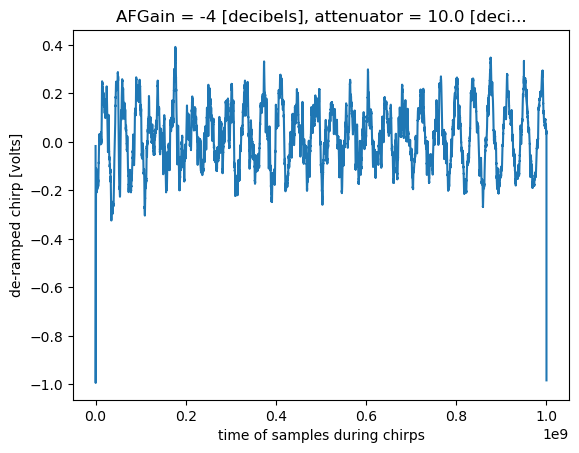

In [30]:
good_bursts.isel(attenuator_setting_pair = 0, time = 0, chirp_num = 5).chirp.plot()